In [2]:
import networkx as nx
import os
import re
import numpy as np
import pickle
import random
import math
import matplotlib.pyplot as plt


In [3]:
# load graph:
S = pickle.load(open("graph.pkl", "rb"))
print(f"Number of nodes: {S.number_of_nodes()}")
print(f"Number of edges: {S.number_of_edges()}")

n_nodes = S.number_of_nodes()
n_edges = S.number_of_edges()

Number of nodes: 1366
Number of edges: 10850


In [4]:
# Turn to undirected graph
S = S.to_undirected()

# Comparison to Barabasi-Albert model graph

In [43]:
def grow_Barabasi_Albert_graph(n=5000, E=None):
    if E is None:
        raise ValueError("Total number of edges E must be specified.")
    if n < 2:
        raise ValueError("Number of nodes n must be at least 2.")
    
    # Function to approximate m from n and E
    def approximate_m(n, E):
        best_m = None
        min_diff = float('inf')
        for m in range(1, n):
            total_edges = m * n - (m * (m + 1)) // 2
            diff = abs(total_edges - E)
            if diff < min_diff:
                min_diff = diff
                best_m = m
            if diff == 0:
                break
        return best_m
    
    m = approximate_m(n, E)
    print(f"Using m = {m} to approximate E = {E}")
    
    # Initialize the graph with a complete graph of m nodes
    F_BA = nx.complete_graph(m)
    
    # Function to get the degree list for preferential attachment
    def get_degree_list(G):
        degree_list = []
        for node in G.nodes:
            degree_list.extend([node] * G.degree[node])
        return degree_list

    # Function to add a new node connected to m existing nodes preferentially
    def add_node_proportional_to_degree(G, new_node, m):
        degree_list = get_degree_list(G)
        targets = set()
        while len(targets) < m:
            target_node = random.choice(degree_list)
            targets.add(target_node)
        for target_node in targets:
            G.add_edge(new_node, target_node)
    
    # Add the remaining n - m nodes
    for new_node in range(m, n):
        add_node_proportional_to_degree(F_BA, new_node, m)
    
    return F_BA

# Example usage
random.seed(42)
F_BA = grow_Barabasi_Albert_graph(n=n_nodes, E=n_edges)


Using m = 8 to approximate E = 10850


In [44]:
print(f"Number of nodes: {F_BA.number_of_nodes()}")
print(f"Number of edges: {F_BA.number_of_edges()}")

Number of nodes: 1366
Number of edges: 10892


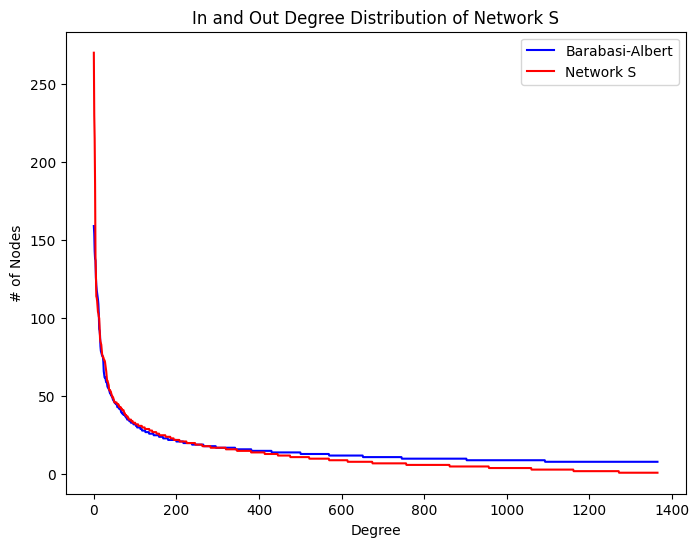

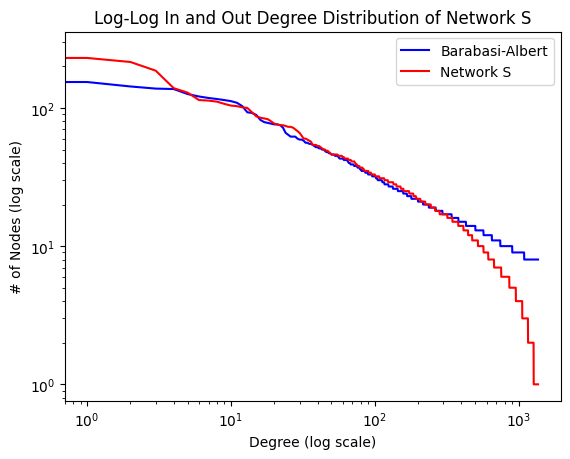

In [45]:
# Plotting the degree distributions
degree_sequence_F_BA = sorted([d for n, d in F_BA.degree()], reverse=True)
degree_sequence_S = sorted([d for n, d in S.degree()], reverse=True)

## Plot setup
plt.figure(figsize=(8, 6))

## Plotting the degree distribution as a linear plot
plt.plot(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.plot(degree_sequence_S, 'r-', label='Network S')

plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.title('In and Out Degree Distribution of Network S')
plt.legend()
plt.show()


## Plotting the degree distribution as a log-log plot
plt.loglog(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.loglog(degree_sequence_S, 'r-', label='Network S')

plt.xlabel('Degree (log scale)')
plt.ylabel('# of Nodes (log scale)')
plt.title('Log-Log In and Out Degree Distribution of Network S')
plt.legend()
plt.show()

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

def compute_network_metrics(graph):
    """Computes and returns key metrics for a graph."""
    metrics = {}
    
    # Degree Distribution
    degrees = [d for _, d in graph.degree()]
    metrics['degree_histogram'] = nx.degree_histogram(graph)
    
    # Clustering Coefficient
    metrics['global_clustering'] = nx.transitivity(graph)
    metrics['average_clustering'] = nx.average_clustering(graph)
    
    # Assortativity
    metrics['assortativity'] = nx.degree_assortativity_coefficient(graph)
    
    # Connected Components
    components = list(nx.connected_components(graph))
    metrics['num_connected_components'] = len(components)
    metrics['largest_component_size'] = len(max(components, key=len))
    
    # Shortest Path Lengths (only for the largest connected component)
    largest_component = graph.subgraph(max(components, key=len)).copy()
    metrics['average_shortest_path'] = nx.average_shortest_path_length(largest_component)
    metrics['diameter'] = nx.diameter(largest_component)
    
    # Degree Centrality
    metrics['degree_centrality'] = nx.degree_centrality(graph)
    
    return metrics

# Compute metrics for both graphs
wiki_metrics = compute_network_metrics(S)
ba_metrics = compute_network_metrics(F_BA)

# Compare metrics
print("Philosopher Wikipedia Graph Metrics:")
for key, value in wiki_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value}")
        
print("\nBarabási-Albert Graph Metrics:")
for key, value in ba_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value}")


Philosopher Wikipedia Graph Metrics:
global_clustering: 0.11652067966280295
average_clustering: 0.2801646258482919
assortativity: -0.1068392379980094
num_connected_components: 1
largest_component_size: 1366
average_shortest_path: 3.0391807314208488
diameter: 8

Barabási-Albert Graph Metrics:
global_clustering: 0.03909360479617193
average_clustering: 0.04361157394576715
assortativity: -0.01900335034757547
num_connected_components: 1
largest_component_size: 1366
average_shortest_path: 2.747196970915858
diameter: 4


# Model Fitting

In [47]:
import pickle
import numpy as np
import networkx as nx
from scipy.stats import poisson, expon, lognorm
import powerlaw
import warnings

# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")

# Step 2: Extract the degree sequence
degrees = np.array([d for n, d in S.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 3: Fit candidate distributions using MLE

# 3a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 3b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 3c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 3d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 4: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 5: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"Poisson: {log_likelihood_poisson}")
print(f"Exponential: {log_likelihood_exp}")
print(f"Log-Normal: {log_likelihood_lognorm}")
print(f"Power-Law: {log_likelihood_powerlaw}\n")

print("AIC values:")
for dist, aic in AICs.items():
    print(f"{dist}: {aic}")
print(f"Best fit according to AIC: {best_fit_aic}\n")

print("BIC values:")
for dist, bic in BICs.items():
    print(f"{dist}: {bic}")
print(f"Best fit according to BIC: {best_fit_bic}\n")

print("Estimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson}")
print(f"Exponential lambda: {lambda_exp}")
print(f"Log-Normal sigma: {sigma_lognorm}, scale: {scale_lognorm}")
print(f"Power-Law alpha: {alpha_powerlaw}, xmin: {xmin_powerlaw}")


Minimum degree: 1
Maximum degree: 270

Model fitting results:
-----------------------
Log-Likelihoods:
Poisson: -12886.754131010563
Exponential: -4891.394126109269
Log-Normal: -4762.912073388454
Power-Law: -5100.349472767519

AIC values:
Poisson: 25775.508262021125
Exponential: 9784.788252218537
Log-Normal: 9529.824146776908
Power-Law: 10204.698945535038
Best fit according to AIC: Log-Normal

BIC values:
Poisson: 25780.727904061256
Exponential: 9790.007894258668
Log-Normal: 9540.263430857169
Power-Law: 10215.138229615299
Best fit according to BIC: Log-Normal

Estimated parameters:
---------------------
Poisson lambda: 13.207906295754027
Exponential lambda: 0.07571222702582862
Log-Normal sigma: 1.041505831824949, scale: 7.592435009787176
Power-Law alpha: 1.4933028324187014, xmin: 1.0


In [48]:
# Step 6: Create Log-Log Plots for Each Model

# Function to plot empirical data and fitted model on log-log scale
def plot_degree_distribution_loglog(degrees, model_name, fitted_params):
    plt.figure(figsize=(8, 6))
    
    # Empirical degree distribution
    degree_counts = np.bincount(degrees)
    degrees_unique = np.nonzero(degree_counts)[0]
    counts = degree_counts[degrees_unique]
    prob = counts / counts.sum()
    
    plt.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
    
    # Generate degrees for plotting fitted model
    x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
    
    if model_name == 'Poisson':
        pmf = poisson.pmf(x, fitted_params['lambda'])
        plt.plot(x, pmf, 'r-', label='Poisson Fit')
    elif model_name == 'Exponential':
        # For discrete plotting, use the CDF to approximate
        # Alternatively, treat as continuous
        pdf = expon.pdf(x, scale=fitted_params['scale'])
        plt.plot(x, pdf, 'g-', label='Exponential Fit')
    elif model_name == 'Log-Normal':
        # Avoid zero by starting from 1
        pdf = lognorm.pdf(x, fitted_params['sigma'], loc=fitted_params['loc'], scale=fitted_params['scale'])
        plt.plot(x, pdf, 'm-', label='Log-Normal Fit')
    elif model_name == 'Power-Law':
        # Power-law PDF: C * x^{-alpha}
        pdf = (x ** (-fitted_params['alpha']))
        # Normalize the PDF over the range xmin to max(x)
        pdf = pdf / pdf.sum()
        plt.plot(x, pdf, 'k-', label='Power-Law Fit')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Probability (log scale)')
    plt.title(f'Degree Distribution with {model_name} Fit')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Prepare fitted parameters for each model
fitted_models = {
    'Poisson': {'lambda': lambda_poisson},
    'Exponential': {'scale': params_exp[1]},  # scale = 1/lambda
    'Log-Normal': {'sigma': sigma_lognorm, 'loc': loc_lognorm, 'scale': scale_lognorm},
    'Power-Law': {'alpha': alpha_powerlaw, 'xmin': xmin_powerlaw}
}

# # Create separate plots for each model
# for model in ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']:
#     plot_degree_distribution_loglog(degrees, model, fitted_models[model])


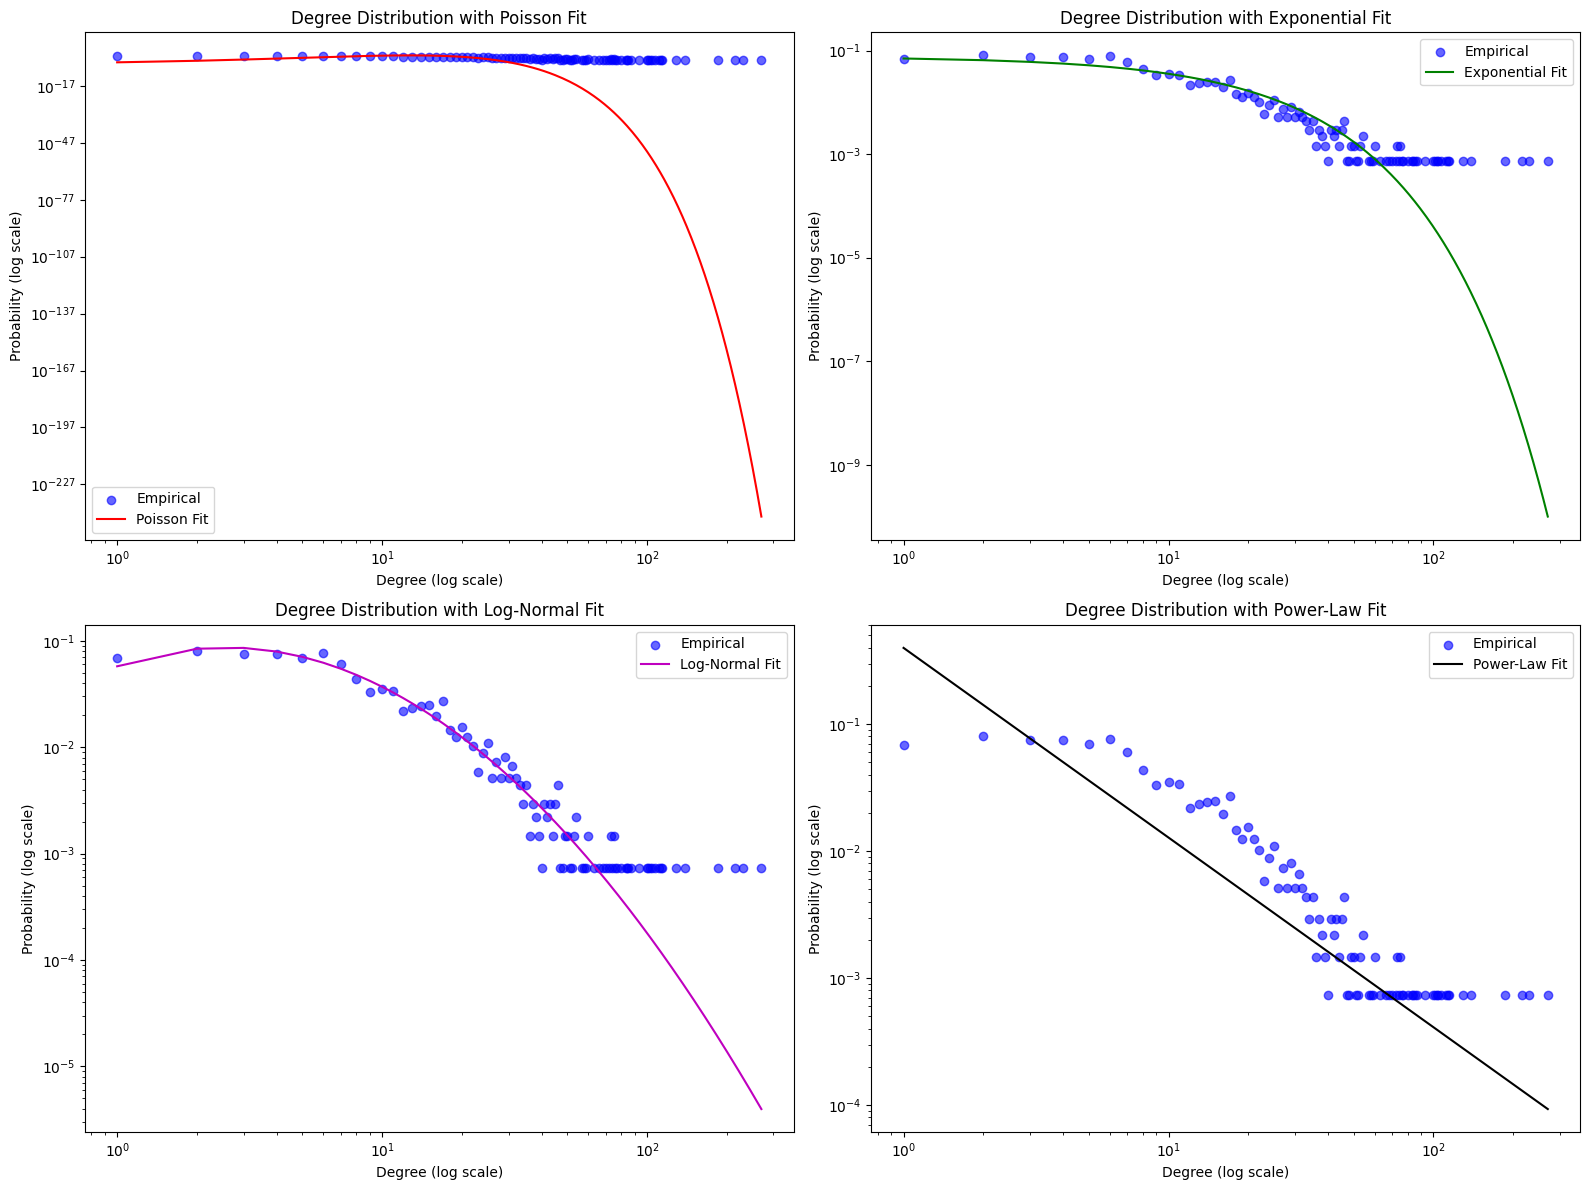

In [49]:
def plot_all_models_loglog(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('Probability (log scale)')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_all_models_loglog(degrees, fitted_models)

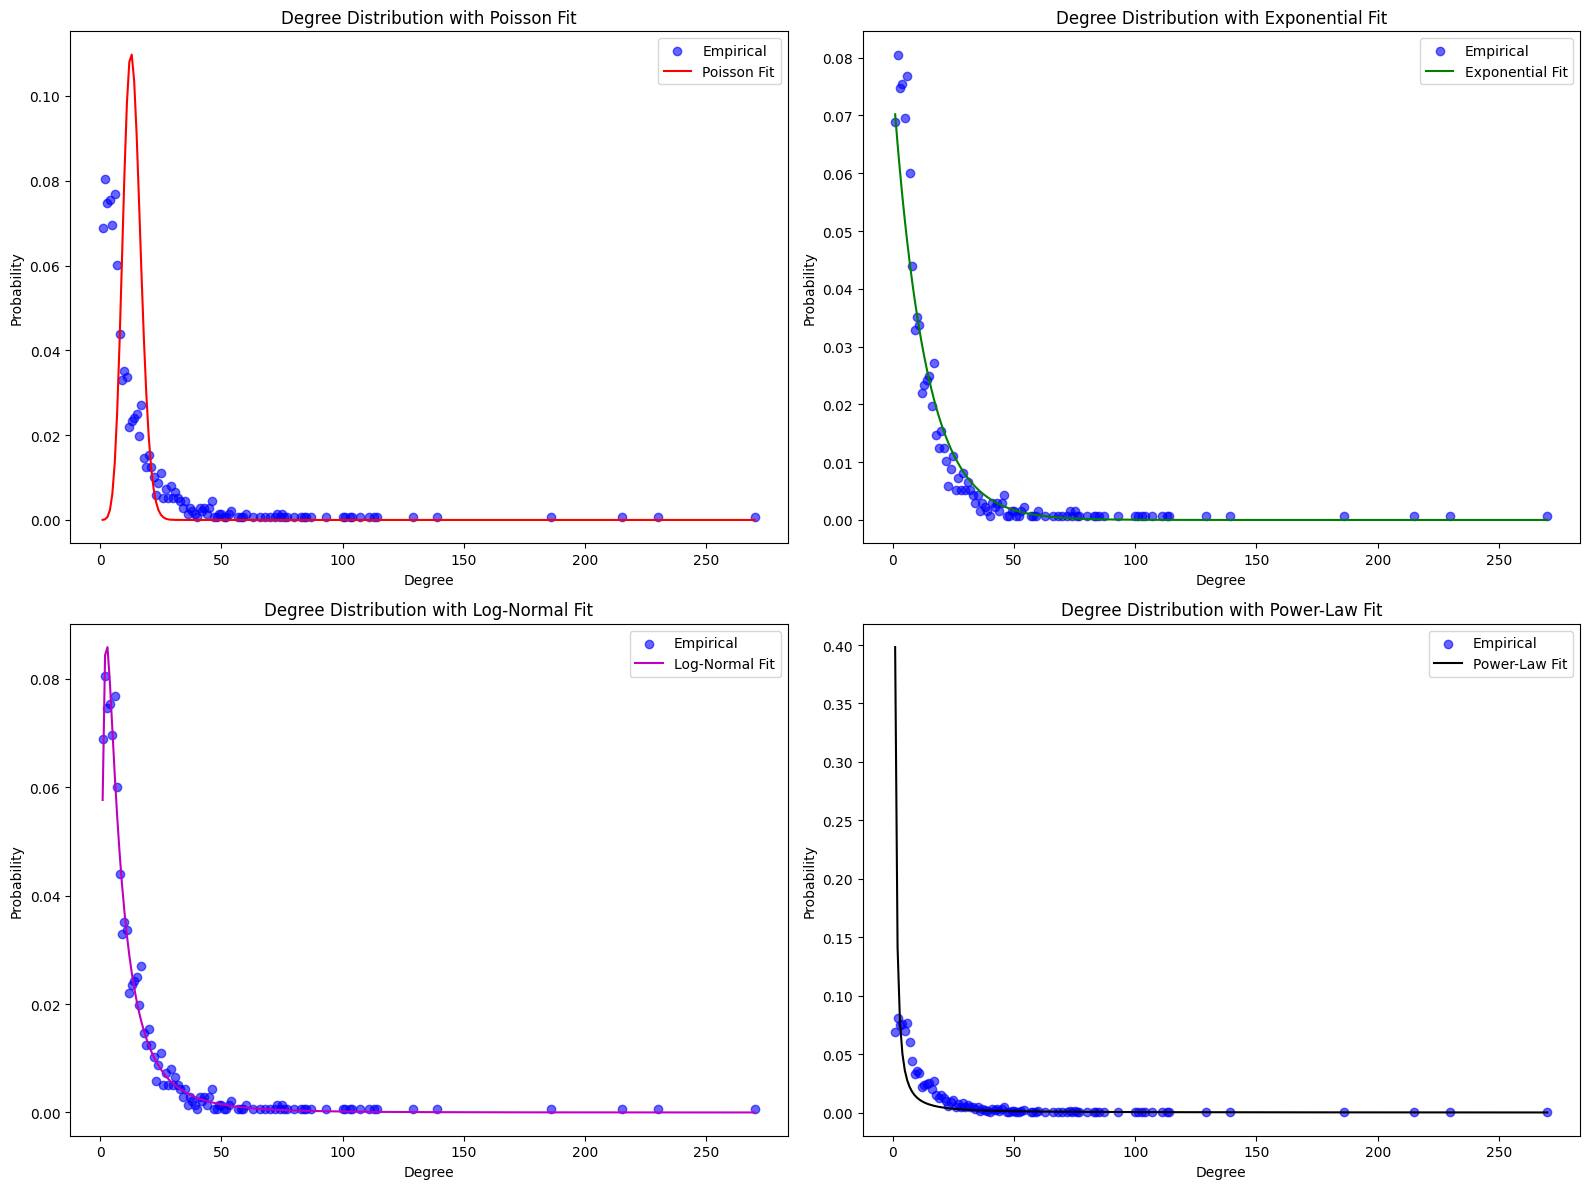

In [50]:
def plot_all_models_linear(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max() + 1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xlabel('Degree')
        ax.set_ylabel('Probability')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call the new function
plot_all_models_linear(degrees, fitted_models)


# Nodes analysis

In [7]:
# Print the 15 highest degree nodes
sorted_degrees = sorted(S.degree, key=lambda x: x[1], reverse=True)
print("Top 30 nodes by degree:")
for node, degree in sorted_degrees[:30]:
    print(f"Node: {node}, Degree: {degree}")

Top 30 nodes by degree:
Node: Aristotle, Degree: 270
Node: Immanuel_Kant, Degree: 230
Node: Plato, Degree: 215
Node: Karl_Marx, Degree: 186
Node: Friedrich_Nietzsche, Degree: 139
Node: David_Hume, Degree: 129
Node: Stanford_Encyclopedia_of_Philosophy, Degree: 114
Node: René_Descartes, Degree: 113
Node: John_Locke, Degree: 111
Node: Martin_Heidegger, Degree: 107
Node: Edmund_Husserl, Degree: 104
Node: Thomas_Aquinas, Degree: 103
Node: Ludwig_Wittgenstein, Degree: 101
Node: Bertrand_Russell, Degree: 100
Node: Sigmund_Freud, Degree: 93
Node: Arthur_Schopenhauer, Degree: 87
Node: Heraclitus, Degree: 85
Node: Baruch_Spinoza, Degree: 84
Node: Cicero, Degree: 83
Node: Jacques_Derrida, Degree: 80
Node: John_Stuart_Mill, Degree: 77
Node: Voltaire, Degree: 76
Node: Socrates, Degree: 75
Node: William_James, Degree: 75
Node: Michel_Foucault, Degree: 74
Node: Henri_Bergson, Degree: 73
Node: Augustine_of_Hippo, Degree: 73
Node: Isaac_Newton, Degree: 72
Node: Charles_Darwin, Degree: 70
Node: Søren_Ki

In [8]:
# Print top 30 highest centrality nodes
sorted_centrality = sorted(nx.degree_centrality(S).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by degree centrality:")
for node, centrality in sorted_centrality[:30]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")


Top 30 nodes by degree centrality:
Node: Aristotle, Degree Centrality: 0.1978
Node: Immanuel_Kant, Degree Centrality: 0.1685
Node: Plato, Degree Centrality: 0.1575
Node: Karl_Marx, Degree Centrality: 0.1363
Node: Friedrich_Nietzsche, Degree Centrality: 0.1018
Node: David_Hume, Degree Centrality: 0.0945
Node: Stanford_Encyclopedia_of_Philosophy, Degree Centrality: 0.0835
Node: René_Descartes, Degree Centrality: 0.0828
Node: John_Locke, Degree Centrality: 0.0813
Node: Martin_Heidegger, Degree Centrality: 0.0784
Node: Edmund_Husserl, Degree Centrality: 0.0762
Node: Thomas_Aquinas, Degree Centrality: 0.0755
Node: Ludwig_Wittgenstein, Degree Centrality: 0.0740
Node: Bertrand_Russell, Degree Centrality: 0.0733
Node: Sigmund_Freud, Degree Centrality: 0.0681
Node: Arthur_Schopenhauer, Degree Centrality: 0.0637
Node: Heraclitus, Degree Centrality: 0.0623
Node: Baruch_Spinoza, Degree Centrality: 0.0615
Node: Cicero, Degree Centrality: 0.0608
Node: Jacques_Derrida, Degree Centrality: 0.0586
Node

In [9]:
# Print top 30 highest betweenness centrality nodes
sorted_betweenness = sorted(nx.betweenness_centrality(S).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by betweenness centrality:")
for node, betweenness in sorted_betweenness[:30]:
    print(f"Node: {node}, Betweenness Centrality: {betweenness:.4f}")


Top 30 nodes by betweenness centrality:
Node: Aristotle, Betweenness Centrality: 0.1379
Node: Immanuel_Kant, Betweenness Centrality: 0.1144
Node: Karl_Marx, Betweenness Centrality: 0.0794
Node: Plato, Betweenness Centrality: 0.0717
Node: Stanford_Encyclopedia_of_Philosophy, Betweenness Centrality: 0.0492
Node: David_Hume, Betweenness Centrality: 0.0467
Node: René_Descartes, Betweenness Centrality: 0.0355
Node: Friedrich_Nietzsche, Betweenness Centrality: 0.0348
Node: Bertrand_Russell, Betweenness Centrality: 0.0338
Node: Thomas_Aquinas, Betweenness Centrality: 0.0323
Node: John_Locke, Betweenness Centrality: 0.0312
Node: Edmund_Husserl, Betweenness Centrality: 0.0284
Node: Ludwig_Wittgenstein, Betweenness Centrality: 0.0260
Node: Baruch_Spinoza, Betweenness Centrality: 0.0199
Node: Martin_Heidegger, Betweenness Centrality: 0.0184
Node: Sigmund_Freud, Betweenness Centrality: 0.0184
Node: John_Stuart_Mill, Betweenness Centrality: 0.0182
Node: Søren_Kierkegaard, Betweenness Centrality: 0

In [10]:
# Print top 30 highest closeness centrality nodes
sorted_closeness = sorted(nx.closeness_centrality(S).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by closeness centrality:")
for node, closeness in sorted_closeness[:30]:
    print(f"Node: {node}, Closeness Centrality: {closeness:.4f}")


Top 30 nodes by closeness centrality:
Node: Immanuel_Kant, Closeness Centrality: 0.5004
Node: Aristotle, Closeness Centrality: 0.4944
Node: Stanford_Encyclopedia_of_Philosophy, Closeness Centrality: 0.4738
Node: Plato, Closeness Centrality: 0.4709
Node: Friedrich_Nietzsche, Closeness Centrality: 0.4582
Node: Bertrand_Russell, Closeness Centrality: 0.4581
Node: Karl_Marx, Closeness Centrality: 0.4565
Node: René_Descartes, Closeness Centrality: 0.4565
Node: David_Hume, Closeness Centrality: 0.4538
Node: Heraclitus, Closeness Centrality: 0.4475
Node: Edmund_Husserl, Closeness Centrality: 0.4449
Node: Martin_Heidegger, Closeness Centrality: 0.4438
Node: John_Locke, Closeness Centrality: 0.4425
Node: John_Stuart_Mill, Closeness Centrality: 0.4413
Node: Baruch_Spinoza, Closeness Centrality: 0.4412
Node: Henri_Bergson, Closeness Centrality: 0.4400
Node: Arthur_Schopenhauer, Closeness Centrality: 0.4390
Node: Gilles_Deleuze, Closeness Centrality: 0.4371
Node: Søren_Kierkegaard, Closeness Cent

In [12]:
# Print top 30 highest eigenvector centrality nodes
sorted_eigenvector = sorted(nx.eigenvector_centrality(S).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by eigenvector centrality:")
for node, eigenvector in sorted_eigenvector[:30]:
    print(f"Node: {node}, Eigenvector Centrality: {eigenvector:.4f}")


Top 30 nodes by eigenvector centrality:
Node: Aristotle, Eigenvector Centrality: 0.2314
Node: Plato, Eigenvector Centrality: 0.2174
Node: Immanuel_Kant, Eigenvector Centrality: 0.2120
Node: Friedrich_Nietzsche, Eigenvector Centrality: 0.1656
Node: Karl_Marx, Eigenvector Centrality: 0.1569
Node: Martin_Heidegger, Eigenvector Centrality: 0.1388
Node: Stanford_Encyclopedia_of_Philosophy, Eigenvector Centrality: 0.1344
Node: David_Hume, Eigenvector Centrality: 0.1308
Node: Heraclitus, Eigenvector Centrality: 0.1289
Node: René_Descartes, Eigenvector Centrality: 0.1283
Node: Edmund_Husserl, Eigenvector Centrality: 0.1150
Node: Bertrand_Russell, Eigenvector Centrality: 0.1095
Node: John_Locke, Eigenvector Centrality: 0.1067
Node: Arthur_Schopenhauer, Eigenvector Centrality: 0.1033
Node: Jacques_Derrida, Eigenvector Centrality: 0.1011
Node: Baruch_Spinoza, Eigenvector Centrality: 0.1008
Node: Sigmund_Freud, Eigenvector Centrality: 0.0981
Node: Michel_Foucault, Eigenvector Centrality: 0.0968
N

In [49]:
# load graph:
S = pickle.load(open("graph.pkl", "rb"))
print(f"Number of nodes: {S.number_of_nodes()}")
print(f"Number of edges: {S.number_of_edges()}")

n_nodes = S.number_of_nodes()
n_edges = S.number_of_edges()

# Identify nodes with "Encyclopedia" in their name
nodes_to_remove = [node for node in S.nodes if "Philosophy" in node]

# Remove these nodes from the graph
S.remove_nodes_from(nodes_to_remove)

# Print confirmation
print(f"Removed {len(nodes_to_remove)} nodes containing 'Philosophy':")
print(nodes_to_remove)

# page rank centrality
page_rank = nx.pagerank(S)
sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by PageRank:")
for node, pr in sorted_page_rank[:30]:
    print(f"Node: {node}, PageRank: {pr:.4f}")

Number of nodes: 1366
Number of edges: 10850
Removed 4 nodes containing 'Philosophy':
['The_Cambridge_Dictionary_of_Philosophy', 'Routledge_Encyclopedia_of_Philosophy', 'The_Oxford_Companion_to_Philosophy', 'Stanford_Encyclopedia_of_Philosophy']

Top 30 nodes by PageRank:
Node: Aristotle, PageRank: 0.0181
Node: Immanuel_Kant, PageRank: 0.0156
Node: Plato, PageRank: 0.0155
Node: Karl_Marx, PageRank: 0.0133
Node: Bertrand_Russell, PageRank: 0.0092
Node: David_Hume, PageRank: 0.0086
Node: John_Locke, PageRank: 0.0084
Node: Friedrich_Nietzsche, PageRank: 0.0079
Node: René_Descartes, PageRank: 0.0078
Node: Charles_Darwin, PageRank: 0.0076
Node: Isaac_Newton, PageRank: 0.0074
Node: Cicero, PageRank: 0.0072
Node: Albert_Einstein, PageRank: 0.0069
Node: Voltaire, PageRank: 0.0067
Node: Thomas_Aquinas, PageRank: 0.0065
Node: Augustine_of_Hippo, PageRank: 0.0064
Node: Martin_Heidegger, PageRank: 0.0064
Node: Sigmund_Freud, PageRank: 0.0058
Node: Ludwig_Wittgenstein, PageRank: 0.0057
Node: John_S

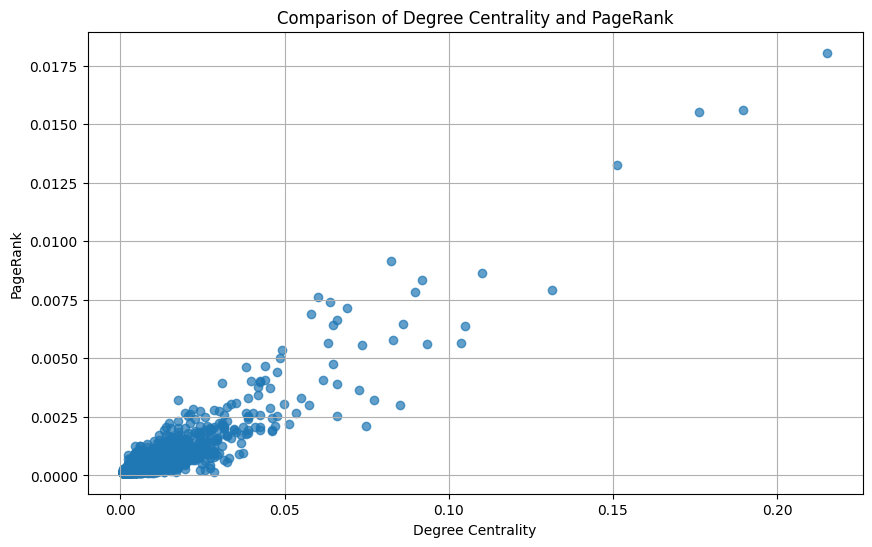

In [50]:
import matplotlib.pyplot as plt

# Get centrality and PageRank values
degree_centrality = nx.degree_centrality(S)
page_rank = nx.pagerank(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(page_rank.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank")
plt.grid(True)
plt.show()


# Summary: Degree Centrality vs. PageRank in the Philosophers' Network

## Key Observations
1. **Overlap in Names**:
   - Both degree centrality and PageRank highlight many of the same philosophers (e.g., Aristotle, Kant, Plato) due to their prominence in the network.
   - Influential nodes are commonly recognized by both measures, but the rankings differ due to their distinct methodologies.

2. **Differences in Rankings**:
   - **Degree Centrality** emphasizes direct mentions (e.g., Aristotle is frequently cited by others, ranking him highly).
   - **PageRank** prioritizes nodes with high-quality incoming links, amplifying the importance of nodes cited by influential pages (e.g., Stanford Encyclopedia of Philosophy).

3. **Key Examples**:
   - Encyclopedias like *Stanford Encyclopedia* and *Routledge Encyclopedia* top the PageRank list because they are cited by highly influential philosophers but have lower degree centrality.
   - Philosophers like **Nietzsche** and **Heidegger** have higher degree centrality due to frequent direct mentions, but lower PageRank if their mentions are not from highly influential nodes.
   - Philosophers like **Adam Smith** and **Vladimir Lenin** appear in the PageRank list due to indirect influence but not in degree centrality.

## Insights
1. **Degree Centrality**:
   - Highlights philosophers with the highest number of direct mentions.
   - Reflects "local" importance in the citation network.

2. **PageRank**:
   - Captures the propagation of influence, prioritizing mentions by highly influential nodes.
   - Reflects "global" importance in the network structure.

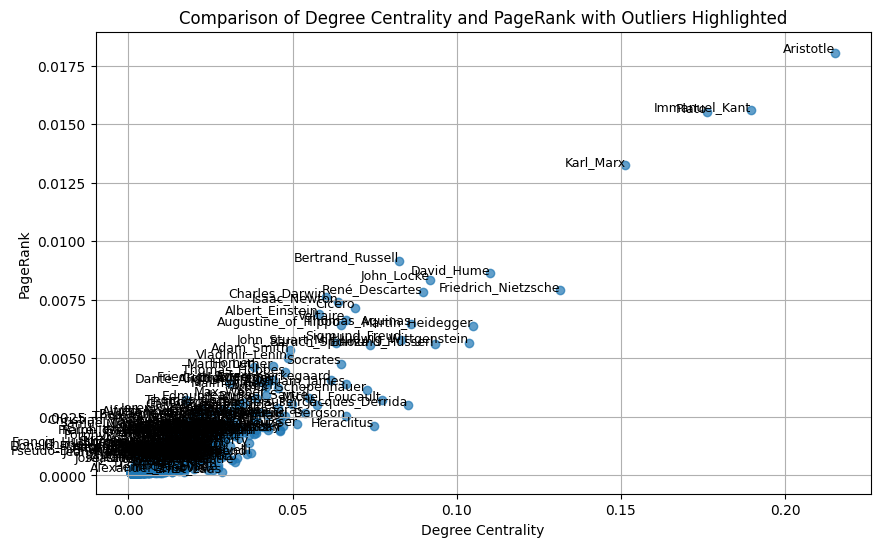

In [51]:
# Define threshold for outliers (adjust based on your dataset)
degree_values = list(degree_centrality.values())
pagerank_values = list(page_rank.values())

# Example criterion: nodes farthest from the trend line or extreme values
threshold = 0.02  # Adjust this value as needed
outliers = [node for node in degree_centrality if 
            abs(degree_centrality[node] - page_rank[node]) > threshold]

# Scatter plot with labels for outliers
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, pagerank_values, alpha=0.7)

# Label outliers
for node in outliers:
    x = degree_centrality[node]
    y = page_rank[node]
    plt.text(x, y, node, fontsize=9, ha='right')

plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank with Outliers Highlighted")
plt.grid(True)
plt.show()


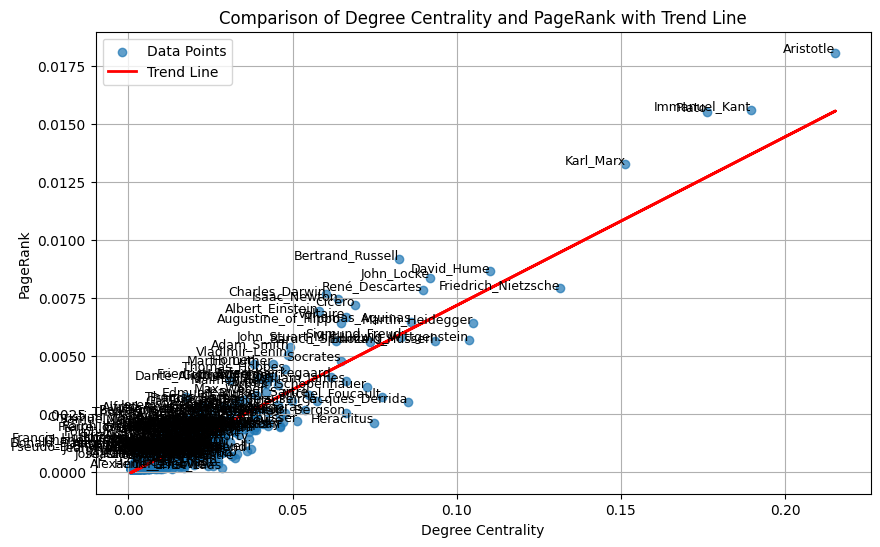

In [52]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare data for linear regression
degree_values = np.array(list(degree_centrality.values())).reshape(-1, 1)
pagerank_values = np.array(list(page_rank.values()))

# Fit a linear regression model
model = LinearRegression()
model.fit(degree_values, pagerank_values)

# Generate predictions for the trend line
trend_line = model.predict(degree_values)

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, pagerank_values, alpha=0.7, label="Data Points")
plt.plot(degree_values, trend_line, color="red", linewidth=2, label="Trend Line")

# Label outliers
threshold = 0.02  # Adjust as needed
outliers = [node for node in degree_centrality if 
            abs(degree_centrality[node] - page_rank[node]) > threshold]
for node in outliers:
    x = degree_centrality[node]
    y = page_rank[node]
    plt.text(x, y, node, fontsize=9, ha='right')

plt.xlabel("Degree Centrality")
plt.ylabel("PageRank")
plt.title("Comparison of Degree Centrality and PageRank with Trend Line")
plt.legend()
plt.grid(True)
plt.show()


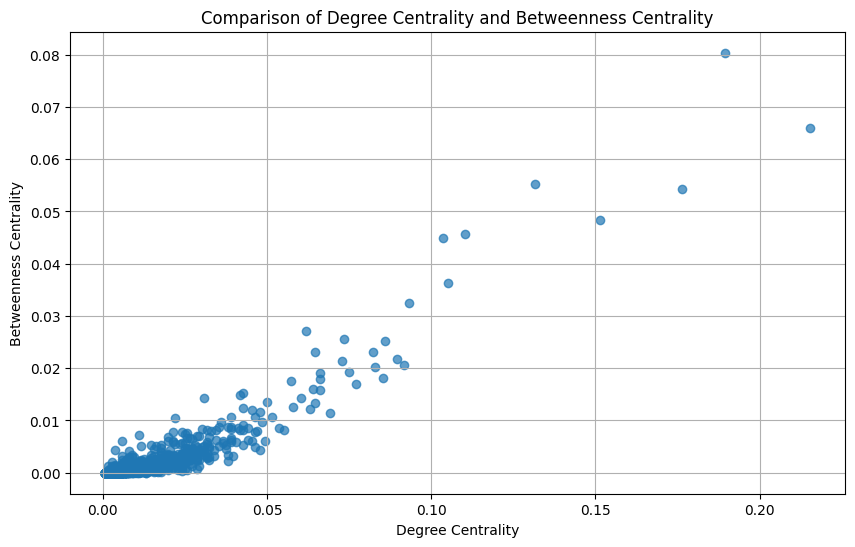

In [53]:
# plot degree centrality vs betweenness centrality
degree_centrality = nx.degree_centrality(S)
betweenness_centrality = nx.betweenness_centrality(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(betweenness_centrality.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Comparison of Degree Centrality and Betweenness Centrality")
plt.grid(True)
plt.show()

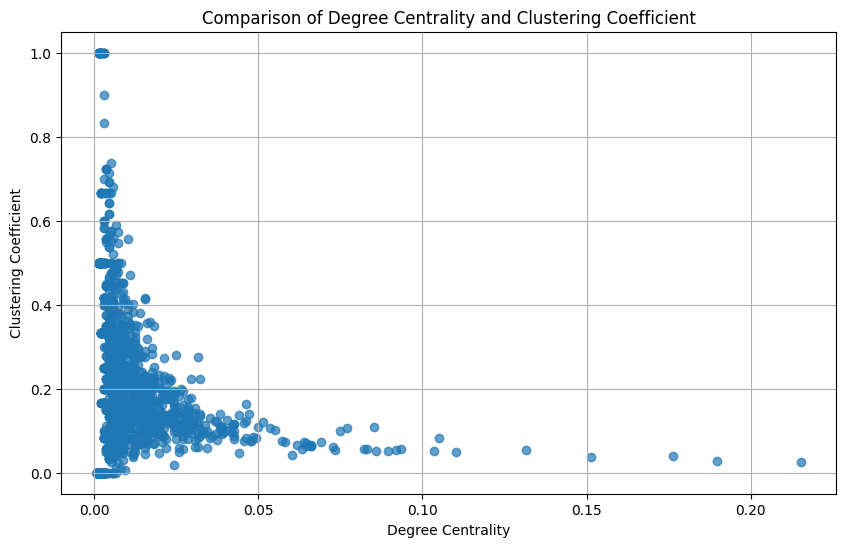

In [54]:
# compute clustering coefficient
clustering_coefficient = nx.clustering(S)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(clustering_coefficient.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Clustering Coefficient")
plt.title("Comparison of Degree Centrality and Clustering Coefficient")
plt.grid(True)
plt.show()

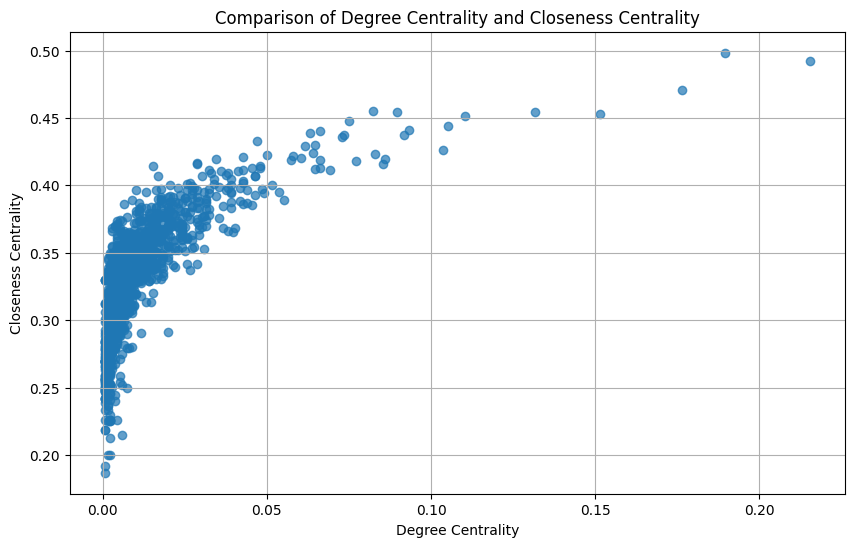

In [55]:
# plot degree centrality vs closeness centrality
degree_centrality = nx.degree_centrality(S)
closeness_centrality = nx.closeness_centrality(S.copy().to_undirected())

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_centrality.values()), list(closeness_centrality.values()), alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Closeness Centrality")
plt.title("Comparison of Degree Centrality and Closeness Centrality")
plt.grid(True)
plt.show()

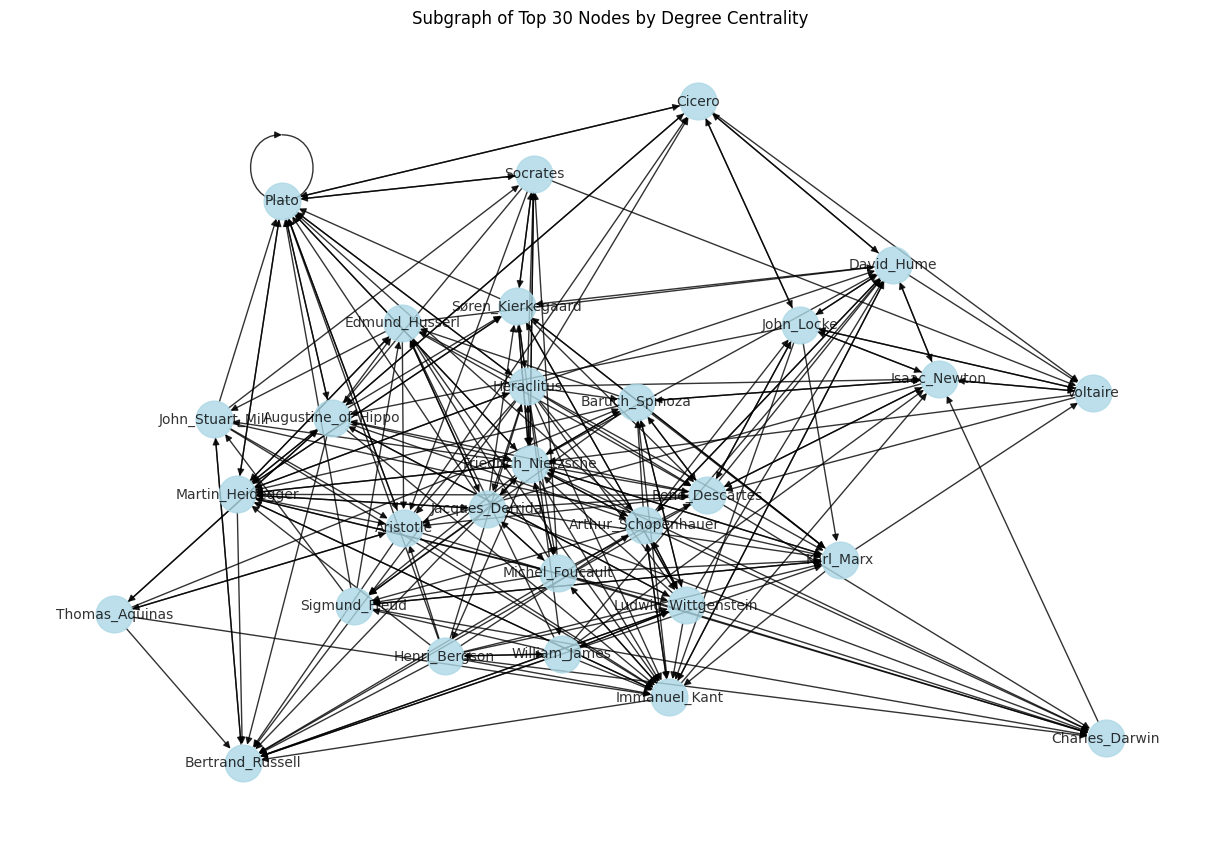

In [56]:
# Step 1: Extract the top 30 nodes by degree centrality
top_30_degree_nodes = [node for node, _ in sorted_centrality[:30]]

# Step 2: Create the subgraph with only these nodes
subgraph = S.subgraph(top_30_degree_nodes)

# Step 3: Visualize the subgraph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=True, node_size=700, node_color="lightblue", alpha=0.8, font_size=10)
plt.title("Subgraph of Top 30 Nodes by Degree Centrality")
plt.show()


C:\Users\medon\AppData\Local\Temp\ipykernel_3872\2709515968.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label="In-Degree Centrality")


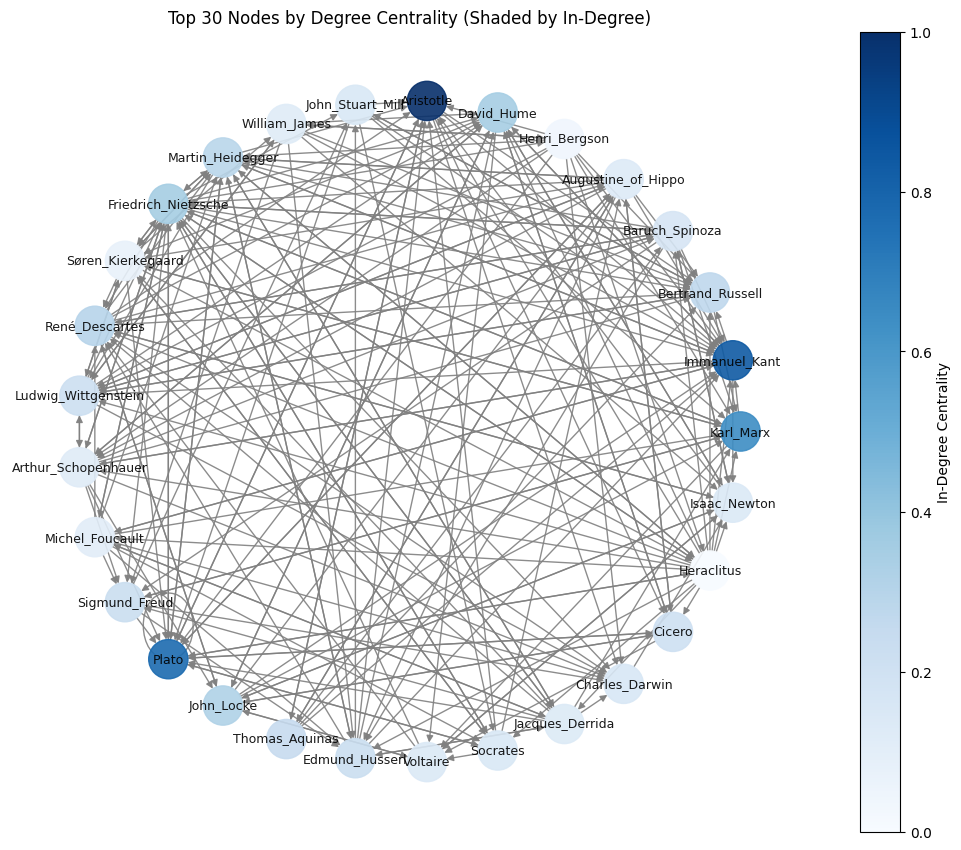

In [57]:
# Step 1: Extract the top 30 nodes by degree centrality
top_30_degree_nodes = [node for node, _ in sorted_centrality[:30]]

# Step 2: Create the subgraph
subgraph = S.subgraph(top_30_degree_nodes)

# Step 3: Calculate in-degree centrality for coloring
in_degree_centrality = nx.in_degree_centrality(S)  # Use the original graph's in-degree centrality
node_colors = [in_degree_centrality[node] for node in subgraph.nodes()]

# Step 4: Visualize with a circular layout
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(subgraph)  # Circular layout
nx.draw(
    subgraph, pos, with_labels=True, 
    node_color=node_colors, cmap=plt.cm.Blues, 
    edge_color="gray",
    node_size=800, alpha=0.9, font_size=9, font_color="black"
)

plt.title("Top 30 Nodes by Degree Centrality (Shaded by In-Degree)")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label="In-Degree Centrality")
plt.show()


In [58]:
#print nodes with highest degree centrality
sorted_centrality = sorted(nx.pagerank(subgraph).items(), key=lambda x: x[1], reverse=True)
for node, centrality in sorted_centrality:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

Node: Isaac_Newton, Degree Centrality: 0.0686
Node: Immanuel_Kant, Degree Centrality: 0.0597
Node: Friedrich_Nietzsche, Degree Centrality: 0.0518
Node: Plato, Degree Centrality: 0.0504
Node: David_Hume, Degree Centrality: 0.0502
Node: Bertrand_Russell, Degree Centrality: 0.0470
Node: Karl_Marx, Degree Centrality: 0.0443
Node: René_Descartes, Degree Centrality: 0.0435
Node: Martin_Heidegger, Degree Centrality: 0.0419
Node: John_Locke, Degree Centrality: 0.0416
Node: Aristotle, Degree Centrality: 0.0416
Node: Voltaire, Degree Centrality: 0.0414
Node: Augustine_of_Hippo, Degree Centrality: 0.0362
Node: Ludwig_Wittgenstein, Degree Centrality: 0.0362
Node: Søren_Kierkegaard, Degree Centrality: 0.0350
Node: Charles_Darwin, Degree Centrality: 0.0311
Node: Cicero, Degree Centrality: 0.0307
Node: Baruch_Spinoza, Degree Centrality: 0.0303
Node: Arthur_Schopenhauer, Degree Centrality: 0.0297
Node: John_Stuart_Mill, Degree Centrality: 0.0280
Node: Sigmund_Freud, Degree Centrality: 0.0248
Node: Edm

In [60]:
philosopher_dates = {
    "Isaac_Newton": 1643,
    "Immanuel_Kant": 1724,
    "Friedrich_Nietzsche": 1844,
    "Plato": -428,
    "David_Hume": 1711,
    "Bertrand_Russell": 1872,
    "Karl_Marx": 1818,
    "René_Descartes": 1596,
    "Martin_Heidegger": 1889,
    "John_Locke": 1632,
    "Aristotle": -384,
    "Voltaire": 1694,
    "Augustine_of_Hippo": 354,
    "Ludwig_Wittgenstein": 1889,
    "Søren_Kierkegaard": 1813,
    "Charles_Darwin": 1809,
    "Cicero": -106,
    "Baruch_Spinoza": 1632,
    "Arthur_Schopenhauer": 1788,
    "John_Stuart_Mill": 1806,
    "Sigmund_Freud": 1856,
    "Edmund_Husserl": 1859,
    "Socrates": -470,
    "Heraclitus": -535,
    "Michel_Foucault": 1926,
    "Jacques_Derrida": 1930,
    "Thomas_Aquinas": 1225,
    "William_James": 1842,
    "Henri_Bergson": 1859,
}


In [39]:
import random

def random_walk(graph, start_node, num_steps=10):
    """Simulate a random walk to study influence flow."""
    current_node = start_node
    path = [current_node]

    for _ in range(num_steps):
        neighbors = list(graph.successors(current_node))  # Directed graph: successors
        if not neighbors:
            break  # Stop if no successors
        current_node = random.choice(neighbors)
        path.append(current_node)

    return path

# Simulate a random walk starting from Aristotle
start_node = "Aristotle"
path = random_walk(S, start_node, num_steps=15)
print(f"Influence path starting from {start_node}:", " → ".join(path))


Influence path starting from Aristotle: Aristotle → Theophrastus → Empedocles → Parmenides → Aristotle → Avicenna → Averroes → Porphyry_(philosopher) → Adolf_von_Harnack → Karl_Barth → Rudolf_Bultmann → Martin_Heidegger → Herbert_Marcuse → Angela_Davis → Herbert_Marcuse → Raya_Dunayevskaya


In [40]:
import networkx as nx

def effective_size(graph, node):
    """Calculate the effective size of a node."""
    neighbors = set(graph.neighbors(node))  # Immediate neighbors
    total_neighbors = len(neighbors)

    if total_neighbors <= 1:
        return total_neighbors  # No structural hole if only 1 neighbor

    redundancy = 0
    for neighbor in neighbors:
        shared_neighbors = set(graph.neighbors(neighbor)) & neighbors
        redundancy += len(shared_neighbors) / total_neighbors

    return total_neighbors - redundancy

# Compute effective size for each node
effective_sizes = {node: effective_size(S, node) for node in S.nodes()}
sorted_effective_sizes = sorted(effective_sizes.items(), key=lambda x: x[1], reverse=True)

# Top philosophers by effective size
print("Top philosophers by effective size (structural holes):")
for node, size in sorted_effective_sizes[:10]:
    print(f"{node}: {size:.2f}")


Top philosophers by effective size (structural holes):
Heraclitus: 63.85
Friedrich_Nietzsche: 63.09
Ludwig_Wittgenstein: 56.18
Jacques_Derrida: 47.07
Henri_Bergson: 47.02
Michel_Foucault: 43.38
Edmund_Husserl: 40.32
Martin_Heidegger: 40.02
David_Hume: 37.76
Arthur_Schopenhauer: 36.60


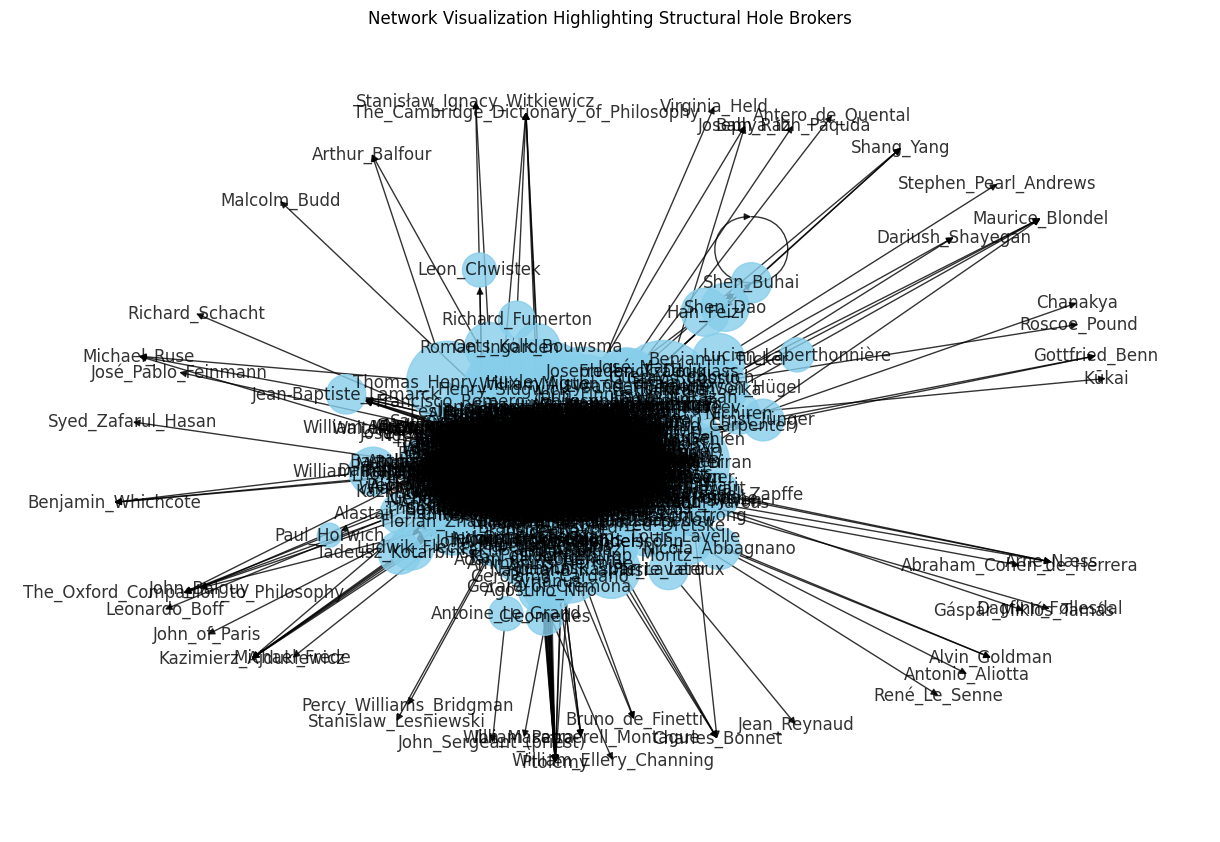

In [41]:
# Scale node sizes by effective size
node_sizes = [effective_sizes[node] * 300 for node in S.nodes()]

plt.figure(figsize=(12, 8))
nx.draw(S, with_labels=True, node_size=node_sizes, node_color="skyblue", alpha=0.8)
plt.title("Network Visualization Highlighting Structural Hole Brokers")
plt.show()
